In [1]:
# regression with Boston housing dataset
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

2022-10-25 21:18:58.950822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# notice that we no longer use labels, but (continuous) target values

train_targets[0]

15.2

In [3]:
# feature-wise normalization: (X - mean) / std
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [4]:
# due to the dataset being small (~500), a small 
# architecture (2 layers - 64 units) can mitigate overfitting.
from keras import models, layers

# helper function
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    
    # a linear layer, so no activation function provided since we want to do regression on a unit value
    model.add(layers.Dense(1))

    # mse is widely used in regression problems
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    # mae (mean absolute error)
    return model

In [5]:
# given that the dataset is very small, validation partitioning is unreliable.
# a common technique is k-fold cross-validation, whereby a set is split in K subsets
# for each subset a model is trained with K - 1 subsets and validated with the remaining one.
# each model uses a different validation subset

In [8]:
# k-fold crossvalidation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f'processing fold # {i}...')
    # get index boundaries
    st = i * num_val_samples
    end = st + num_val_samples
    val_data = train_data[st:end]
    val_targets = train_targets[st:end]
    
    # excluse validation set
    partial_train_data = np.concatenate(
        [train_data[:st], train_data[end:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:st], train_targets[end:]],
        axis=0
    )
    # build, and fit model
    model = build_model()
    history = model.fit(
        partial_train_data, 
        partial_train_targets, 
        validation_data=(val_data, val_targets),
        epochs=num_epochs, 
        batch_size=1, 
        verbose=0)
    # append results
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
print('mae histories: ', all_mae_histories)

processing fold # 0...
processing fold # 1...
processing fold # 2...
processing fold # 3...
mae histories:  [[3.5656254291534424, 2.9511470794677734, 2.898268699645996, 2.4499175548553467, 2.880537271499634, 2.467484951019287, 2.159620761871338, 2.54074764251709, 2.4396636486053467, 2.096883535385132, 2.3557379245758057, 2.0722172260284424, 2.157916307449341, 1.999291181564331, 2.123209238052368, 2.0896353721618652, 2.024886131286621, 2.020372152328491, 1.9923887252807617, 1.9372594356536865, 1.7944144010543823, 2.4059109687805176, 1.9292064905166626, 2.0795626640319824, 1.893129825592041, 1.9552640914916992, 1.835371971130371, 2.609987258911133, 2.0273597240448, 2.2084224224090576, 1.9140878915786743, 1.9290300607681274, 1.845504641532898, 1.8037229776382446, 1.7610918283462524, 1.8165462017059326, 1.9426907300949097, 2.1012790203094482, 2.212933301925659, 1.7170765399932861, 1.799480676651001, 1.7367072105407715, 1.8679189682006836, 1.7891228199005127, 1.829940676689148, 1.7301234006

In [9]:
# get the fold-wise average of each epoch
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

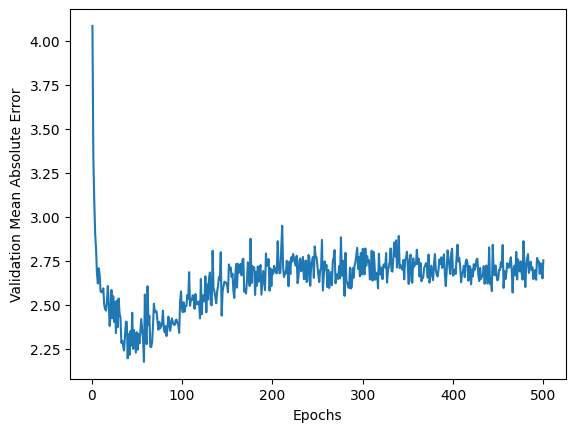

In [10]:
# plot histories
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Mean Absolute Error')
plt.show()

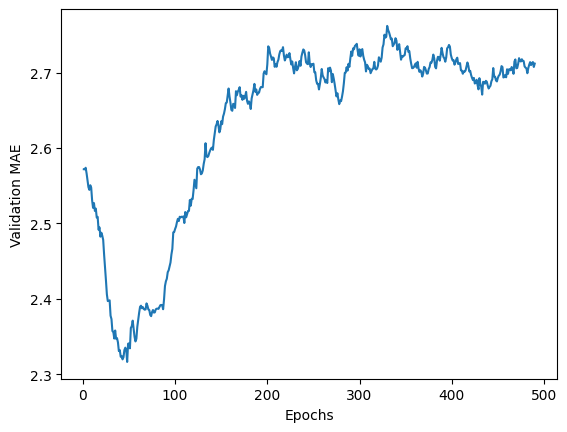

In [11]:
# remove first 10 points and smooth curve
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
# since model peaks at around 80 epochs, build a new one and check results
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 1ms/step - loss: 16.8694 - mae: 2.6042


2.60420823097229